In [53]:
# Future imports
from __future__ import annotations

# Standard library imports
import csv
import os
import sys
import warnings
from typing import Set

# Third-party imports
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import soundfile as sf
import tensorflow as tf
import torch
import whisper
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    accuracy_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.layers import (
    Add,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling1D,
    Input,
    LayerNormalization,
    MultiHeadAttention,
)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, Model
from tqdm import tqdm



In [46]:
import pandas as pd

# Read the input CSV file
df = pd.read_csv("C:/Users/yingx/OneDrive/Documents/GitHub/Capstone/data/static_annotations_averaged_songs_1_2000.csv")

# Define a function to determine emotion
def get_emotion(row):
    val = row["valence_mean"]
    aro = row["arousal_mean"]

    if val < 4.9 and aro < 4.9:
        return "Sad"
    elif val < 4.9 and aro >= 4.9:
        return "Anger"
    elif val >= 4.9 and aro < 4.9:
        return "Relaxed"
    elif val >= 4.9 and aro >= 4.9:
        return "Happy"
    else:
        print("Error in determining emotion for row:", row)
        return "Unknown"

# Apply the function to each row
df["emotion"] = df.apply(get_emotion, axis=1)

# Print counts for each emotion
print("Emotion counts:")
print(df["emotion"].value_counts())

# Create a new DataFrame with only id and emotion
output = df[["song_id", "emotion"]].rename(columns={"song_id": "id"})

# Save to a new CSV file
output.to_csv("emotion2.csv", index=False)

print("emotion2.csv has been created successfully!")


Emotion counts:
emotion
Happy      666
Sad        623
Relaxed    233
Anger      222
Name: count, dtype: int64
emotion2.csv has been created successfully!


In [48]:
# Merge features.csv, transcription.csv, static_annotations_averaged_songs.csv, and emotion.csv into a singular CSV file

# Read csv
features_df = pd.read_csv(r'C:/Users/yingx/data/features.csv')
transcription_df = pd.read_csv(r'C:/Users/yingx/data/transcription.csv')
emotion_df = pd.read_csv(r'C:/Users/yingx/OneDrive/Documents/GitHub/Capstone/emotion2.csv')

# Merge on 'id' cloumn
merged_df = features_df.merge(transcription_df, on='id', how='left').merge(emotion_df, on='id', how='left')

# Save the merged DataFrame to a new CSV file
merged_df.to_csv(r'C:/Users/yingx/data/merged_data.csv', index=False)
print("Data merged successfully into merged_data.csv")


Data merged successfully into merged_data.csv


In [50]:
# Split the merged data into training and testing sets
# 1. Read the merged data
merged_df = pd.read_csv(r'C:/Users/yingx/data/merged_data.csv')
# 2. Keep only rows where emotion is not NaN (only labeled songs)
labeled_df = merged_df.dropna(subset=['emotion'])
# 3. Define features and target
X = labeled_df.drop(columns=['id', 'emotion'])
y = labeled_df['emotion']
# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

print("Train data columns:", X_train.columns)

# Save to CSV
X_train.to_csv(r'C:/Users/yingx/data/X_train.csv', index=False)
X_test.to_csv(r'C:/Users/yingx/data/X_test.csv', index=False)
y_train.to_csv(r'C:/Users/yingx/data/y_train.csv', index=False)
y_test.to_csv(r'C:/Users/yingx/data/y_test.csv', index=False)

print("Split completed successfully!")


Train shape: (1395, 9) (1395,)
Test shape: (349, 9) (349,)
Train data columns: Index(['duration', 'tempo', 'spectral_centroid', 'zero_crossing_rate',
       'chroma_feature', 'mfccs', 'rms', 'harmonicity', 'transcription'],
      dtype='object')
Split completed successfully!


In [51]:
# Preprocessing and dataset creation for CNN-Transformer model
def preprocess_features(X, y=None, label_encoder=None,
                        tokenizer=None, max_text_len=None,
                        is_training=True):
    """
    Preprocess features for CNN-Transformer model
    """
    processed_features = {}
    
    # 1. Process numerical features
    numerical_features = ['duration', 'tempo', 'spectral_centroid', 'zero_crossing_rate', 'rms', 'harmonicity']
    for feature in numerical_features:
        if feature in X.columns:
            values = X[feature].values.astype(np.float32)
            # Normalize numerical features
            if is_training:
                # Store normalization parameters for test set
                processed_features[f'{feature}_mean'] = np.mean(values)
                processed_features[f'{feature}_std'] = np.std(values)
            values = (values - processed_features.get(f'{feature}_mean', 0)) / max(processed_features.get(f'{feature}_std', 1), 1e-8)
            processed_features[feature] = values
    
    # 2. Process chroma features (convert string representation to arrays)
    if 'chroma_feature' in X.columns:
        chroma_features = []
        for chroma_str in X['chroma_feature']:
            if isinstance(chroma_str, str):
                try:
                    chroma_array = np.array(ast.literal_eval(chroma_str), dtype=np.float32)
                    chroma_features.append(chroma_array)
                except:
                    chroma_features.append(np.zeros(12, dtype=np.float32))
            else:
                chroma_features.append(np.zeros(12, dtype=np.float32))
        
        chroma_features = np.array(chroma_features)
        # Normalize chroma features
        if is_training:
            processed_features['chroma_mean'] = np.mean(chroma_features, axis=0)
            processed_features['chroma_std'] = np.std(chroma_features, axis=0)
        chroma_features = (chroma_features - processed_features.get('chroma_mean', 0)) / np.maximum(processed_features.get('chroma_std', 1), 1e-8)
        processed_features['chroma'] = chroma_features
    
    # 3. Process MFCC features
    if 'mfccs' in X.columns:
        mfcc_features = []
        for mfcc_str in X['mfccs']:
            if isinstance(mfcc_str, str):
                try:
                    mfcc_array = np.array(ast.literal_eval(mfcc_str), dtype=np.float32)
                    mfcc_features.append(mfcc_array)
                except:
                    mfcc_features.append(np.zeros(20, dtype=np.float32))
            else:
                mfcc_features.append(np.zeros(20, dtype=np.float32))
        
        mfcc_features = np.array(mfcc_features)
        # Normalize MFCC features
        if is_training:
            processed_features['mfcc_mean'] = np.mean(mfcc_features, axis=0)
            processed_features['mfcc_std'] = np.std(mfcc_features, axis=0)
        mfcc_features = (mfcc_features - processed_features.get('mfcc_mean', 0)) / np.maximum(processed_features.get('mfcc_std', 1), 1e-8)
        processed_features['mfcc'] = mfcc_features
    
        # 4. Process text features (transcription) for Transformer
    if 'transcription' in X.columns:
        texts = X['transcription'].fillna('').astype(str).tolist()

        # Use a proper tokenizer (Keras Tokenizer -> integer sequences)
        from tensorflow.keras.preprocessing.text import Tokenizer
        from tensorflow.keras.preprocessing.sequence import pad_sequences

        if is_training:
            # You can tune num_words if you want to limit vocab size
            tokenizer = Tokenizer(num_words=None,  # or e.g. 10000
                                  oov_token="<OOV>")
            tokenizer.fit_on_texts(texts)

            sequences = tokenizer.texts_to_sequences(texts)

            # Decide max length (can be fixed or based on training data)
            max_text_len = max(len(seq) for seq in sequences) or 1

            padded = pad_sequences(
                sequences,
                maxlen=max_text_len,
                padding='post',
                truncating='post'
            )

            processed_features['text_input'] = padded.astype('int32')
            processed_features['tokenizer'] = tokenizer
            processed_features['max_text_len'] = max_text_len

        else:
            # Reuse tokenizer and max_text_len learned from training data
            if tokenizer is None or max_text_len is None:
                raise ValueError("Tokenizer and max_text_len must be provided for is_training=False")

            sequences = tokenizer.texts_to_sequences(texts)
            padded = pad_sequences(
                sequences,
                maxlen=max_text_len,
                padding='post',
                truncating='post'
            )

            processed_features['text_input'] = padded.astype('int32')

    # 5. Process target labels
    if y is not None:
        if is_training:
            label_encoder = LabelEncoder()
            y_encoded = label_encoder.fit_transform(y)
            processed_features['label_encoder'] = label_encoder
        else:
            y_encoded = label_encoder.transform(y)
        processed_features['labels'] = y_encoded
        processed_features['num_classes'] = len(label_encoder.classes_)
    
    return processed_features

def create_dataset(features_dict, batch_size=32, shuffle=True):
    """
    Create TensorFlow dataset from processed features
    """
    # Prepare input features for CNN-Transformer
    inputs = {}
    
    # Numerical features - reshape for CNN
    numerical_features = ['duration', 'tempo', 'spectral_centroid', 'zero_crossing_rate', 'rms', 'harmonicity']
    numerical_data = []
    for feature in numerical_features:
        if feature in features_dict:
            numerical_data.append(features_dict[feature].reshape(-1, 1))
    
    if numerical_data:
        numerical_stack = np.stack(numerical_data, axis=1)  # Shape: (batch_size, num_numerical_features, 1)
        inputs['numerical_input'] = numerical_stack
    
    # Chroma features - reshape for CNN (12 chroma bins)
    if 'chroma' in features_dict:
        chroma_data = features_dict['chroma']
        inputs['chroma_input'] = chroma_data.reshape(-1, chroma_data.shape[1], 1)
    
    # MFCC features - reshape for CNN (20 MFCC coefficients)
    if 'mfcc' in features_dict:
        mfcc_data = features_dict['mfcc']
        inputs['mfcc_input'] = mfcc_data.reshape(-1, mfcc_data.shape[1], 1)
    
    # Text features (token ids for Transformer)
    if 'text_input' in features_dict:
        text_data = features_dict['text_input']
        inputs['text_input'] = text_data  # shape: (num_samples, max_text_len)

    # Create dataset
    if 'labels' in features_dict:
        dataset = tf.data.Dataset.from_tensor_slices((inputs, features_dict['labels']))
    else:
        dataset = tf.data.Dataset.from_tensor_slices(inputs)
    
    if shuffle and 'labels' in features_dict:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Main preprocessing pipeline
def prepare_cnn_transformer_data(X_train, X_test, y_train, y_test):
    """
    Complete data preparation for CNN-Transformer model
    """
    print("Starting data preprocessing...")
    
    # Preprocess training data
    train_features = preprocess_features(X_train, y_train, is_training=True)
    
    # Preprocess test data using training statistics
    test_features = preprocess_features(
        X_test, y_test,
        label_encoder=train_features['label_encoder'],
        tokenizer=train_features.get('tokenizer'),
        max_text_len=train_features.get('max_text_len'),
        is_training=False
        )
    
    # Create TensorFlow datasets
    batch_size = 32
    train_dataset = create_dataset(train_features, batch_size=batch_size, shuffle=True)
    test_dataset = create_dataset(test_features, batch_size=batch_size, shuffle=False)
    
    # Get input dimensions
    input_dims = {}
    if 'numerical_input' in next(iter(train_dataset))[0]:
        input_dims['numerical'] = train_features['duration'].shape[0]  # number of numerical features
    
    if 'chroma_input' in next(iter(train_dataset))[0]:
        input_dims['chroma'] = train_features['chroma'].shape[1]  # chroma feature length
    
    if 'mfcc_input' in next(iter(train_dataset))[0]:
        input_dims['mfcc'] = train_features['mfcc'].shape[1]  # MFCC feature length
    
    print("Data preprocessing completed!")
    print(f"Number of classes: {train_features['num_classes']}")
    print(f"Class names: {train_features['label_encoder'].classes_}")
    
    return train_dataset, test_dataset, train_features, input_dims

# Usage with your data
print("Preparing training data...")
train_dataset, test_dataset, train_features, input_dims = prepare_cnn_transformer_data(
    X_train, X_test, y_train, y_test
)

# Print dataset information
print("\nDataset Information:")
print(f"Training batches: {len(list(train_dataset))}")
print(f"Test batches: {len(list(test_dataset))}")
print(f"Input dimensions: {input_dims}")

# Example of accessing one batch
for batch_inputs, batch_labels in train_dataset.take(1):
    print(f"\nBatch inputs keys: {batch_inputs.keys()}")

    for key, value in batch_inputs.items():
        print(f"{key} shape: {value.shape}")

    print(f"Batch labels shape: {batch_labels.shape}")
    break

print("Data preparation for CNN-Transformer completed successfully!")

Preparing training data...
Starting data preprocessing...
Data preprocessing completed!
Number of classes: 4
Class names: ['Anger' 'Happy' 'Relaxed' 'Sad']

Dataset Information:
Training batches: 44
Test batches: 11
Input dimensions: {'numerical': 1395, 'chroma': 12, 'mfcc': 20}

Batch inputs keys: dict_keys(['numerical_input', 'chroma_input', 'mfcc_input', 'text_input'])
numerical_input shape: (32, 6, 1)
chroma_input shape: (32, 12, 1)
mfcc_input shape: (32, 20, 1)
text_input shape: (32, 197)
Batch labels shape: (32,)
Data preparation for CNN-Transformer completed successfully!


In [54]:
# Build CNN Transformer model

def create_cnn_block(input_layer, filters, kernel_size, pool_size, dropout_rate=0.3, name_prefix=""):
    """Create a CNN block with convolution, batch norm, and dropout"""
    x = layers.Conv1D(filters, kernel_size, padding='same', activation='relu',
                      name=f'{name_prefix}_conv1')(input_layer)
    x = layers.BatchNormalization(name=f'{name_prefix}_bn1')(x)
    x = layers.MaxPooling1D(pool_size, name=f'{name_prefix}_pool1')(x)
    x = layers.Dropout(dropout_rate, name=f'{name_prefix}_dropout1')(x)

    x = layers.Conv1D(filters * 2, kernel_size, padding='same', activation='relu',
                      name=f'{name_prefix}_conv2')(x)
    x = layers.BatchNormalization(name=f'{name_prefix}_bn2')(x)
    x = layers.MaxPooling1D(pool_size, name=f'{name_prefix}_pool2')(x)
    x = layers.Dropout(dropout_rate, name=f'{name_prefix}_dropout2')(x)

    return x

def create_transformer_block(input_tensor, num_heads, ff_dim, dropout_rate=0.3, name_prefix=""):
    """Create a Transformer block with multi-head attention and feed forward network"""
    d_model = int(input_tensor.shape[-1])      # e.g. 16
    head_size = d_model // num_heads           # e.g. 4

    # Multi-Head Self-Attention
    attention_output = layers.MultiHeadAttention(
        key_dim=head_size,
        num_heads=num_heads,
        dropout=dropout_rate,
        name=f'{name_prefix}_attention'
    )(input_tensor, input_tensor)

    # Residual + LayerNorm 1
    x = layers.Add(name=f'{name_prefix}_add1')([input_tensor, attention_output])
    x = layers.LayerNormalization(epsilon=1e-6, name=f'{name_prefix}_ln1')(x)

    # Feed-Forward
    ff_output = layers.Dense(ff_dim, activation='relu', name=f'{name_prefix}_ff_dense1')(x)
    ff_output = layers.Dropout(dropout_rate, name=f'{name_prefix}_ff_dropout')(ff_output)
    ff_output = layers.Dense(d_model, name=f'{name_prefix}_ff_dense2')(ff_output)

    # Residual + LayerNorm 2
    x = layers.Add(name=f'{name_prefix}_add2')([x, ff_output])
    x = layers.LayerNormalization(epsilon=1e-6, name=f'{name_prefix}_ln2')(x)

    return x


def build_cnn_transformer_model(input_dims, num_classes):
    """
    Build CNN-Transformer model for multi-modal audio feature input

    Args:
        input_dims: Dictionary with input dimensions (not heavily used here yet)
        num_classes: Number of emotion classes (4 in your case)
    """
    # 1. Numerical Features Branch (6 features)
    numerical_input = layers.Input(shape=(6, 1), name='numerical_input')
    numerical_cnn = create_cnn_block(
        numerical_input,
        filters=32,
        kernel_size=3,
        pool_size=2,
        name_prefix="numerical"
    )

    # 2. Chroma Features Branch (12 chroma bins)
    chroma_input = layers.Input(shape=(12, 1), name='chroma_input')
    chroma_cnn = create_cnn_block(
        chroma_input,
        filters=64,
        kernel_size=3,
        pool_size=2,
        name_prefix="chroma"
    )

    # 3. MFCC Features Branch (20 MFCC coefficients)
    mfcc_input = layers.Input(shape=(20, 1), name='mfcc_input')
    mfcc_cnn = create_cnn_block(
        mfcc_input,
        filters=64,
        kernel_size=3,
        pool_size=2,
        name_prefix="mfcc"
    )

    # Global pooling for each branch
    numerical_global = layers.GlobalAveragePooling1D(name='numerical_global_pool')(numerical_cnn)
    chroma_global    = layers.GlobalAveragePooling1D(name='chroma_global_pool')(chroma_cnn)
    mfcc_global      = layers.GlobalAveragePooling1D(name='mfcc_global_pool')(mfcc_cnn)

    # Concatenate audio features
    concatenated = layers.Concatenate(name='feature_concat')([
        numerical_global,
        chroma_global,
        mfcc_global
    ])

    # Dense layers before Transformer
    x = layers.Dense(256, activation='relu', name='dense_1')(concatenated)
    x = layers.BatchNormalization(name='bn_dense1')(x)
    x = layers.Dropout(0.4, name='dropout_dense1')(x)

    x = layers.Dense(128, activation='relu', name='dense_2')(x)
    x = layers.BatchNormalization(name='bn_dense2')(x)
    x = layers.Dropout(0.3, name='dropout_dense2')(x)

    # Project to sequence for Transformer: 8 × 16 = 128
    sequence_length = 8
    d_model = 16
    x = layers.Dense(sequence_length * d_model, activation='relu', name='projection_dense')(x)
    x = layers.Reshape((sequence_length, d_model), name='reshape_for_transformer')(x)

    # Transformer blocks
    x = create_transformer_block(
        x,
        num_heads=4,
        ff_dim=64,
        dropout_rate=0.3,
        name_prefix="transformer1"
    )

    x = create_transformer_block(
        x,
        num_heads=4,
        ff_dim=64,
        dropout_rate=0.3,
        name_prefix="transformer2"
    )

    # Pooling after Transformer
    x = layers.GlobalAveragePooling1D(name='transformer_global_pool')(x)

    # Final classification head
    x = layers.Dense(64, activation='relu', name='final_dense1')(x)
    x = layers.BatchNormalization(name='final_bn')(x)
    x = layers.Dropout(0.2, name='final_dropout')(x)

    outputs = layers.Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(
        inputs=[numerical_input, chroma_input, mfcc_input],
        outputs=outputs,
        name='CNN_Transformer_Emotion_Classifier'
    )

    return model

# Build the model
print("Building CNN-Transformer model...")
model = build_cnn_transformer_model(input_dims, num_classes=4)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model built successfully!")
model.summary()

# Plot model architecture (optional)
try:
    tf.keras.utils.plot_model(
        model, 
        to_file='cnn_transformer_model.png', 
        show_shapes=True, 
        show_layer_names=True,
        expand_nested=True
    )
    print("Model architecture saved as 'cnn_transformer_model.png'")
except:
    print("Could not plot model architecture - but model is built successfully!")

# Calculate class weights for imbalanced data (if any)
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_features['labels']),
    y=train_features['labels']
)
class_weight_dict = dict(enumerate(class_weights))

print(f"Class weights: {class_weight_dict}")

# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=50,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=100,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_cnn_transformer_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

# Train the model
print("Starting model training...")
history = model.fit(
    train_dataset,
    epochs=300,
    validation_data=test_dataset,
    class_weight=class_weight_dict,
    #callbacks=callbacks, # Stop using EarlyStopping for now
    verbose=1
)

print("Model training completed!")

Building CNN-Transformer model...
Model built successfully!
Model: "CNN_Transformer_Emotion_Classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 numerical_input (InputLayer)   [(None, 6, 1)]       0           []                               
                                                                                                  
 chroma_input (InputLayer)      [(None, 12, 1)]      0           []                               
                                                                                                  
 mfcc_input (InputLayer)        [(None, 20, 1)]      0           []                               
                                                                                                  
 numerical_conv1 (Conv1D)       (None, 6, 32)        128         ['numerical_input[0][0]']        
     

c:\Users\yingx\OneDrive\Documents\GitHub\Capstone\.venv\lib\site-packages\keras\engine\functional.py:637: UserWarning: Input dict contained keys ['text_input'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


44/44 [==============================] - 8s 43ms/step - loss: 1.8028 - accuracy: 0.2581 - val_loss: 1.3667 - val_accuracy: 0.3811
Epoch 2/300
44/44 [==============================] - 1s 21ms/step - loss: 1.8259 - accuracy: 0.2588 - val_loss: 1.3970 - val_accuracy: 0.1261
Epoch 3/300
44/44 [==============================] - 1s 23ms/step - loss: 1.6959 - accuracy: 0.2573 - val_loss: 1.4069 - val_accuracy: 0.1261
Epoch 4/300
44/44 [==============================] - 1s 21ms/step - loss: 1.6583 - accuracy: 0.2817 - val_loss: 1.3944 - val_accuracy: 0.1261
Epoch 5/300
44/44 [==============================] - 1s 23ms/step - loss: 1.6376 - accuracy: 0.2796 - val_loss: 1.3918 - val_accuracy: 0.1261
Epoch 6/300
44/44 [==============================] - 1s 22ms/step - loss: 1.5966 - accuracy: 0.2867 - val_loss: 1.3651 - val_accuracy: 0.1232
Epoch 7/300
44/44 [==============================] - 1s 22ms/step - loss: 1.6029 - accuracy: 0.2824 - val_loss: 1.3882 - val_accuracy: 0.1261
Epoch 8/300
44/44 

=== Overall Metrics ===
Accuracy      : 0.1347
F1 (macro)    : 0.0593
F1 (weighted) : 0.0320

=== Classification Report ===
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00        44
       Happy       0.00      0.00      0.00       133
     Relaxed       0.13      1.00      0.24        47
         Sad       0.00      0.00      0.00       125

    accuracy                           0.13       349
   macro avg       0.03      0.25      0.06       349
weighted avg       0.02      0.13      0.03       349

=== Confusion Matrix (raw) ===
[[  0   0  44   0]
 [  0   0 133   0]
 [  0   0  47   0]
 [  0   0 125   0]]


c:\Users\yingx\OneDrive\Documents\GitHub\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yingx\OneDrive\Documents\GitHub\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yingx\OneDrive\Documents\GitHub\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

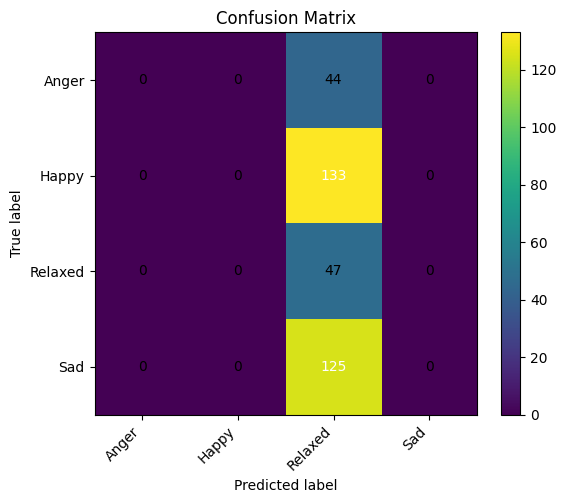

In [55]:
# Evaluation cell: confusion matrix, F1, precision, recall, etc.

# 1. Collect true labels and predictions from the test_dataset
y_true = []
y_pred = []

for batch_inputs, batch_labels in test_dataset:
    # Get predicted probabilities
    probs = model.predict(batch_inputs, verbose=0)
    # Convert to class indices
    preds = np.argmax(probs, axis=1)

    y_true.extend(batch_labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Basic metrics
acc = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("=== Overall Metrics ===")
print(f"Accuracy      : {acc:.4f}")
print(f"F1 (macro)    : {f1_macro:.4f}")
print(f"F1 (weighted) : {f1_weighted:.4f}")

# 3. Classification report (per-class precision/recall/F1)
if 'label_encoder' in train_features:
    class_names = train_features['label_encoder'].classes_
else:
    # Fallback to numeric labels if encoder not available
    class_names = [str(i) for i in np.unique(y_true)]

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

# 4. Confusion matrix
cm = confusion_matrix(y_true, y_pred)

print("=== Confusion Matrix (raw) ===")
print(cm)

# 5. Optional: pretty plot of the confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title("Confusion Matrix")
plt.colorbar(im, ax=ax)

tick_marks = np.arange(len(class_names))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticklabels(class_names)

ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")

# Annotate cells
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()


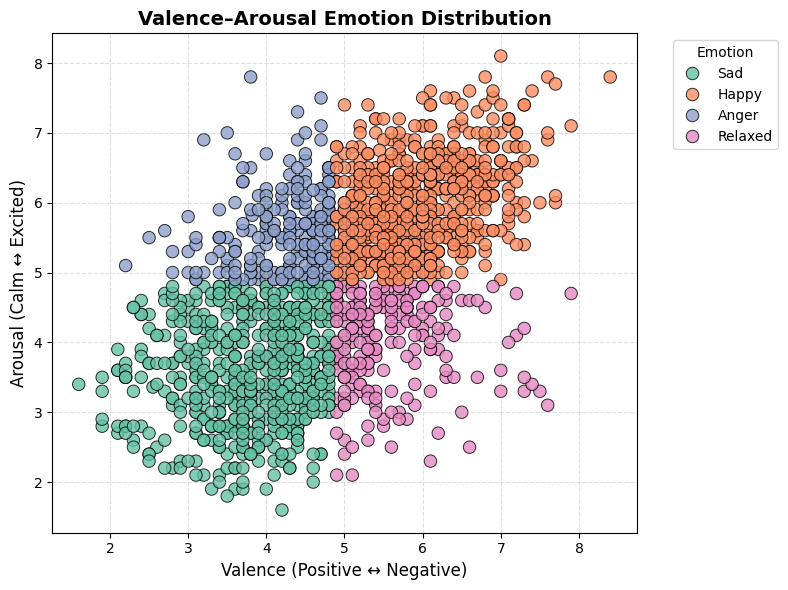

In [57]:
import seaborn as sns

# Use the static annotations dataframe `df` which already contains valence_mean, arousal_mean and emotion.
# Rename song_id -> id for consistency if needed.
plot_df = df[['song_id', 'valence_mean', 'arousal_mean', 'emotion']].rename(columns={'song_id': 'id'})

# Clean any label whitespace
plot_df['emotion'] = plot_df['emotion'].astype(str).str.strip()

# --- Plot ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=plot_df,
    x='valence_mean',
    y='arousal_mean',
    hue='emotion',
    palette='Set2',
    s=80,
    edgecolor='k',
    alpha=0.8
)

plt.title('Valence–Arousal Emotion Distribution', fontsize=14, weight='bold')
plt.xlabel('Valence (Positive ↔ Negative)', fontsize=12)
plt.ylabel('Arousal (Calm ↔ Excited)', fontsize=12)
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()